# IMAGINE tutorial 6
## Personalization and extension

Here we review the design of the IMAGINE pipeline and
demonstrate how to personalise or extend it, quickly designing
each of its components

### Outline (aka advice for quick reading)

* **Theorists/modellers** interested in including/constraining a new model of a quantity previously known to IMAGINE find all they need reading about [Fields and Factories](#Fields-and-Factories).  They may also want to think about their [Fields and Factories](#Priors) while exploring the parameter space.
* **Observers** interested in replacing an existing dataset, may want to jump to [Handling observational data](#Handling-observational-data)
* If one wants to include a completely new **observable quantity** or **dependence on a field** they should go through the previous sections and look at [Simulators](#Observables-and-Observable-dictionaries).
* For any other case, just read through.


## Fields and Factories

Within the IMAGINE pipeline, spatially varying physical quantities are represented by
[Field objects](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#module-imagine.fields).
This can be a *scalar*, as the number density of thermal electrons, or a *vector*, as the Galactic magnetic field. 



In order to extend or personalise adding in one's own model for an specific field, 
one needs to follow a small number of simple steps:  
1. choose a **coordinate grid** where your model will be evaluated,
2. write a **field class**, and
3. write a **field factory** class.

The **field objects** will do the actual computation of the physical field, given a set of physical parameters and a coordinate grid. 
The **field factory objects** take care of book-keeping tasks: e.g. they hold the parameter ranges and default values, and translate the dimensionless parameters used by the sampler (always in the interval $[0,1]$) to physical parameters.

### Coordinate grid

You can create your own coordinate grid by subclassing [`imagine.fields.grid.BaseGrid`](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#imagine.fields.grid.BaseGrid).  The only thing which has to actually be programmed in the new sub-class is a
method overriding [`generate_coordinates()`](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#imagine.fields.grid.BaseGrid.generate_coordinates), which produces a dictionary of numpy arrays containing coordinates in *either* cartesian,
cylindrical or spherical coordinates (generally assumed, in Galactic contexts, to be centred in the centre of the Milky Way).

Typically, however, it is sufficient to use a simple grid with coordinates uniformly-spaced in cartesian, spherical or cylindrical 
coordinates. This can be done using the [`UniformGrid`](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#imagine.fields.grid.UniformGrid) class. `UniformGrid` objects are initialized with the arguments: `box`, which contains the ranges of each coordinate in $\rm kpc$ or $\rm rad$; `resolution`, a list of integers containing the number of grid points on each dimension; and `grid_type`, which can be either 'cartesian' (default), 'cylindrical' or 'spherical'.

In [1]:
import imagine as img
import numpy as np
import astropy.units as u

# A cartesian grid can be constructed as follows
cartesian_grid = img.UniformGrid(box=[[-15*u.kpc, 15*u.kpc],
                                      [-15*u.kpc, 15*u.kpc],
                                      [-15*u.kpc, 15*u.kpc]],
                          resolution = [15,15,15])

# For cylindrical grid, the limits are specified assuming 
# the order: r (cylindrical), phi, z
cylindrical_grid = img.UniformGrid(box=[[0.25*u.kpc, 15*u.kpc],
                                        [-180*u.deg, np.pi*u.rad],
                                        [-15*u.kpc, 15*u.kpc]],
                      resolution = [9,12,9],
                      grid_type = 'cylindrical')

# For spherical grid, the limits are specified assuming 
# the order: r (spherical), theta, phi (azimuth)
spherical_grid = img.UniformGrid(box=[[0*u.kpc, 15*u.kpc],
                                      [0*u.rad, np.pi*u.rad], 
                                      [-np.pi*u.rad,np.pi*u.rad]],
                      resolution = [12,10,10],
                      grid_type = 'spherical')

The grid object will produce the grid only when the a coordinate value is first accessed, 
through the properties 'x', 'y','z','r_cylindrical','r_spherical', 'theta' and 'phi'. 

The grid object also takes care of any coordinate conversions that are needed, for example:

In [2]:
print(spherical_grid.x[5,5,5], cartesian_grid.r_spherical[5,5,5])

6.309658489079476 kpc 7.423074889580904 kpc


In the following figure we illustrate the effects of different choices of 'grid_type' while using UniformGrid. 

(Note that, for plotting purposes, everything is converted to cartesian coordinates)

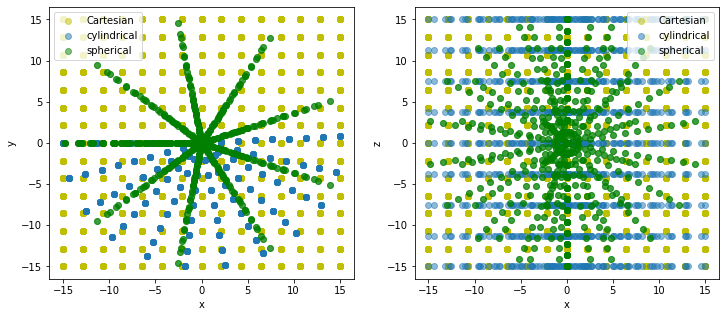

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(cartesian_grid.x, cartesian_grid.y, color='y', label='Cartesian', alpha=0.5)
plt.scatter(cylindrical_grid.x, cylindrical_grid.y, label='cylindrical', alpha=0.5)
plt.scatter(spherical_grid.x, spherical_grid.y, color='g', label='spherical', alpha=0.5)
plt.xlabel('x'); plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(cartesian_grid.x, cartesian_grid.z, color='y', label='Cartesian', alpha=0.5)
plt.scatter(cylindrical_grid.x, cylindrical_grid.z, label='cylindrical', alpha=0.5)
plt.scatter(spherical_grid.x, spherical_grid.z, label='spherical', color='g', alpha=0.5)
plt.xlabel('x'); plt.ylabel('z')
plt.legend();




### Field objects

As we mentioned before, [`Field`](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#module-imagine.fields.field) objects handle the calculation of any physical field.

To ensure that your new personalised field is compatible with any simulator,
it needs to be a subclass of one of the [pre-defined field classes](https://imagine-code.readthedocs.io/en/latest/physical_fields.html). Some examples of which are:
 * `MagneticField`
 * `ThermalElectronDensity`
 * `CosmicRayDistribution`

Let us illustrate this by defining a thermal electron number density field 
which decays exponentially with cylindrical radius, $R$, .
$$ n_e(R) = n_{e,0} e^{-R/R_e} e^{-|z|/h_e} $$
This has three parameters: the number density of thermal electrons at the 
centre, $n_{e,0}$, the scale radius, $R_e$, and the scale height, $h_e$.



In [4]:
from imagine import ThermalElectronDensityField

class ExponentialThermalElectrons(ThermalElectronDensityField):
    """Example: thermal electron density of an (double) exponential disc"""
    
    field_name = 'exponential_disc_thermal_electrons'
    
    @property
    def field_checklist(self):
        return {'central_density' : None, 
                'scale_radius' : None,
                'scale_height' : None}
    
    def get_field(self):
        R = self.grid.r_cylindrical
        z = self.grid.z
        Re = self.parameters['scale_radius']
        he = self.parameters['scale_height']
        n0 = self.parameters['central_density']
        
        return n0*np.exp(-R/Re)*np.exp(-np.abs(z/he))

With these few lines we have created our IMAGINE-compatible™ thermal electron density field class!

The class-attribute `field_name` allows one to keep track of which model we have used to generate our field. 

The `field_checklist` property is a dictionary whose keys are required parameters for this particular kind of field. The values in the dictionary can be used for specialized checking by some simulators (but can be left as `None` in the general case).

The function `get_field` is what actually computes the density field. Note that it can access an associated grid object, which is stored in the `grid` attribute.

Let us now see this at work. First, let us creat an instance of `ExponentialThermalElectrons`. Any Field instance should be initialized 
providing a Grid object and a dictionary of parameters.

In [5]:
electron_distribution = ExponentialThermalElectrons(
    parameters={'central_density': 1.0*u.cm**-3,
                'scale_radius': 3.3*u.kpc,
                'scale_height': 3.3*u.kpc},
    grid=cartesian_grid)

IMAGINE will access the field produced by `cr_distribution` *only using the* `data` attribute. For example:

In [6]:
electron_distribution.data[3:5,3:5,3:5]

<Quantity [[[0.00189093, 0.00361981],
            [0.00289678, 0.0055453 ]],

           [[0.00289678, 0.0055453 ],
            [0.00473694, 0.00906791]]] 1 / cm3>

If we now wanted to plot the thermal electron density computed by this as a function of, say, *spherical radius*, $r_{\rm sph}$. This can be done in the following way

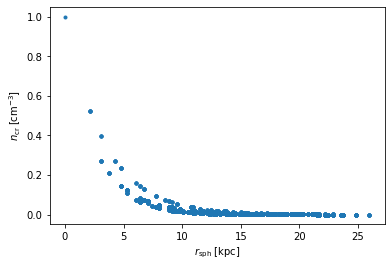

In [7]:
# The spherical radius can be read from the grid object
rspherical = electron_distribution.grid.r_spherical.ravel()
# The electron density is the data array
ne = electron_distribution.data.ravel()

plt.plot(rspherical, ne, '.')
plt.xlabel(r'$r_{\rm sph}\;[\rm kpc]$'); plt.ylabel(r'$n_{\rm cr}\;[\rm cm^{-3}]$');

Let us do another simple field example: a constant magnetic field.

It follows the same basic template.

In [8]:
from imagine import MagneticField
    
class ConstantMagneticField(MagneticField):
    """Example: constant magnetic field"""
    field_name = 'constantB'
    
    @property
    def field_checklist(self):
        return {'Bx': None, 'By': None, 'Bz': None}
    
    def get_field(self):
        # Creates an empty array to store the result
        B = np.empty(self.data_shape) * self.parameters['Bx'].unit
        # For a magnetic field, the output must be of shape: 
        # (Nx,Ny,Nz,Nc) where Nc is the index of the component. 
        # Computes Bx
        B[:,:,:,0] = self.parameters['Bx']*np.ones(self.grid.shape)
        # Computes By
        B[:,:,:,1] = self.parameters['By']*np.ones(self.grid.shape)
        # Computes Bz
        B[:,:,:,2] = self.parameters['Bz']*np.ones(self.grid.shape)        
        return B

The main difference from the thermal electrons case is that the shape of the final array has to accomodate all the three components of the magnetic field.

As before, we can generate a realisation of this

In [9]:
p = {'Bx': 1.5*u.microgauss, 'By': 1e-10*u.Tesla, 'Bz': 0.1e-6*u.gauss}
B = ConstantMagneticField(parameters=p, grid=cartesian_grid)

And inspect how it went

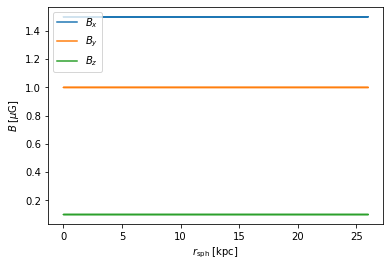

In [10]:
r_spherical = B.grid.r_spherical.ravel()

for i, name in enumerate(['x','y','z']):
    plt.plot(r_spherical, B.data[...,i].ravel(), 
             label='$B_{}$'.format(name))
plt.xlabel(r'$r_{\rm sph}\;[\rm kpc]$'); plt.ylabel(r'$B\;[\mu\rm G]$')
plt.legend();

More information about the field can be found inspecting the object

In [11]:
print('Field type: ', B.field_type)
print('Data shape: ', B.data_shape)
print('What is each axis? Answer:', B.data_description)

Field type:  magnetic_field
Data shape:  (15, 15, 15, 3)
What is each axis? Answer: ['grid_x', 'grid_y', 'grid_z', 'component (x,y,z)']


### Field factory

Associated with each Field class we need to prepare a FieldFactory class, which will take care (separately) of the scaling of parameter ranges, setting default values and priors over each parameter. This is can done through the  following simple templates

In [12]:
from imagine import GeneralFieldFactory

class ExponentialThermalElectrons_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ExponentialThermalElectrons
        self.default_parameters = {'central_density': 1*u.cm**-3,
                                   'scale_radius': 3.0*u.kpc,
                                   'scale_height': 0.5*u.kpc}
        self.priors = {'central_density': FlatPrior(interval=[0,10]*u.cm**-3),
                       'scale_radius': FlatPrior(interval=[1,10]*u.kpc),
                       'scale_height': FlatPrior(interval=[1e-3,5]*u.kpc)}
        
class ConstantMagneticField_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ConstantMagneticField
        self.default_parameters = {'Bx': 0.0*u.microgauss,
                                   'By': 5.0*u.microgauss,
                                   'Bz': 0.0*u.microgauss}
        
        self.priors = {'Bx': img.FlatPrior(interval=[-30, 30]*u.microgauss),
                       'By': img.FlatPrior(interval=[-30, 30]*u.microgauss),
                       'Bz': img.FlatPrior(interval=[-10, 10]*u.microgauss)}

We can now create instances of any of these.  The priors, defaults and also parameter ranges can be accessed using the related properties:

In [13]:
Bfactory = ConstantMagneticField_Factory(grid=cartesian_grid)

Bfactory.default_parameters, Bfactory.parameter_ranges, Bfactory.priors

({'Bx': <Quantity 0. uG>, 'By': <Quantity 5. uG>, 'Bz': <Quantity 0. uG>},
 {'Bx': <Quantity [-30.,  30.] uG>,
  'By': <Quantity [-30.,  30.] uG>,
  'Bz': <Quantity [-10.,  10.] uG>},
 {'Bx': <imagine.priors.basic_priors.FlatPrior at 0x7fde88461d10>,
  'By': <imagine.priors.basic_priors.FlatPrior at 0x7fde884618d0>,
  'Bz': <imagine.priors.basic_priors.FlatPrior at 0x7fde88461a90>})

These instances can return Field objects through the 
`generate` method.

In [14]:
newB = Bfactory.generate()
newB.field_name, newB.parameters

('constantB',
 {'Bx': <Quantity 0. uG>, 'By': <Quantity 5. uG>, 'Bz': <Quantity 0. uG>})

The parameters were all set to their default values.
In practice, before the factory object is used, the pipeline 
first sets a list of *active* parameters 
(inactive parameters are keept with their default values)

In [15]:
Bfactory.active_parameters = ['Bx']

The `generate` method can then be called with a dictionary containing *scaled* *dimensionless* variables as values

In [16]:
dimensionless_scaled_variables = {'Bx': 0.7}  # This is NOT 0.7 microgauss!
newB = Bfactory.generate(variables=dimensionless_scaled_variables)
newB.parameters

{'Bx': <Quantity 12. uG>, 'By': <Quantity 5. uG>, 'Bz': <Quantity 0. uG>}

We see that the value corresponds to the 70% of the range between $-30$ and $30\,\mu \rm G$

In the previous definitions, a flat (i.e. uniform) prior was assumed for all the parameters. Setting up a personalised prior is discussed in detail in the [Priors](#Priors) section below. Here we demonstrate how to setup a (truncated) Gaussian prior for the parameters `Bx` and `By`. The priors can be included creating an object `GaussianPrior` for which the mean, standard deviation and range are specified:

In [17]:
muG = u.microgauss

class ConstantMagneticField_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ConstantMagneticField
        self.default_parameters = {'Bx': 0.0*muG,
                                   'By': 5.0*muG,
                                   'Bz': 0.0*muG}
        self.priors = {'Bx': img.GaussianPrior(mu=0.0*muG, sigma=10*muG, 
                                               interval=[-30, 30]*muG),
                       'By': img.GaussianPrior(mu=5.0*muG, sigma=5*muG, 
                                               interval=[-30, 30]*muG),
                       'Bz': img.FlatPrior(interval=[-10, 10]*muG)}

Let us now inspect an instance of updated field factory

In [18]:
Bfactory = ConstantMagneticField_Factory(grid=cartesian_grid)
Bfactory.priors

{'Bx': <imagine.priors.basic_priors.GaussianPrior at 0x7fde90d55a10>,
 'By': <imagine.priors.basic_priors.GaussianPrior at 0x7fde88414510>,
 'Bz': <imagine.priors.basic_priors.FlatPrior at 0x7fde88414a50>}

We can visualise the selected priors through auxiliary methods in the objects. E.g.

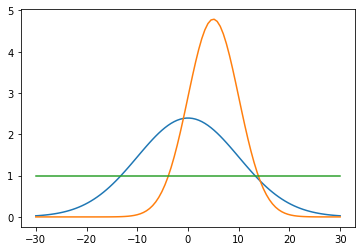

In [19]:
b = np.linspace(-30,30,100)*muG
plt.plot(b, Bfactory.priors['Bx'].pdf_unscaled(b))
plt.plot(b, Bfactory.priors['By'].pdf_unscaled(b))
plt.plot(b, Bfactory.priors['Bz'].pdf_unscaled(b))

Check more in [Priors](#Priors) section.

## Handling observational data

'Observable dictionaries' are the way observational and simulated data are organised within IMAGINE. There are three types of Observable dictionaries: `Measurements`, `Simulations` and `Covariances`.  But before discussing how to directly include
observables in a `Measurements` object, we show how to use the helper 
`Dataset` class.

### Datasets

The easiest way of including data in the Observable dictonaries is using *Datasets*.
Let us illustrate this with the Faraday depth map obtained by Oppermann et al. 2012 ([arXiv:1111.6186](https://arxiv.org/abs/1111.6186)). 

The following snippet will download the [data](https://wwwmpa.mpa-garching.mpg.de/ift/faraday/2012/index.html) (a ~4MB FITS file) to RAM and opens it.

In [20]:
import requests, io
from astropy.io import fits

download = requests.get('https://wwwmpa.mpa-garching.mpg.de/ift/faraday/2012/faraday.fits')
raw_dataset = fits.open(io.BytesIO(download.content))
raw_dataset.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  TEMPERATURE    1 BinTableHDU     17   196608R x 1C   [E]   
  2  signal uncertainty    1 BinTableHDU     17   196608R x 1C   [E]   
  3  Faraday depth    1 BinTableHDU     17   196608R x 1C   [E]   
  4  Faraday uncertainty    1 BinTableHDU     17   196608R x 1C   [E]   
  5  galactic profile    1 BinTableHDU     17   196608R x 1C   [E]   
  6  angular power spectrum of signal    1 BinTableHDU     12   384R x 1C   [E]   


Now we will feed this into an IMAGINE `Dataset`. It requires 
converting the data into a proper numpy array of floats. 
To allow this notebook running on a small memory laptop, we
will also reduce the size of the arrays (only taking 1 value every 256).

In [21]:
from imagine.observables.dataset import FaradayDepthHEALPixDataset
import numpy as np
from astropy import units as u

# Adjusts the data to the right format
fd_raw = raw_dataset[3].data.astype(np.float)
sigma_fd_raw = raw_dataset[4].data.astype(np.float)
# Makes it small, to save memory
fd_raw = fd_raw[::256]
sigma_fd_raw = sigma_fd_raw[::256]
# We need to include units the data
# (this avoids later errors and inconsistencies)
fd_raw *= u.rad/u.m/u.m
sigma_fd_raw *= u.rad/u.m/u.m
# Loads into a Dataset
dset = FaradayDepthHEALPixDataset(data=fd_raw, error=sigma_fd_raw)

One important assumption in the previous code-block is that the covariance matrix is diagonal, i.e. that the errors in FD are *uncorrelated*. 
If this is not
the case, instead of initializing the `FaradayDepthHEALPixDataset` with `data` and `error`, one should initialize it with `data` and `cov`, where the latter
is the correct covariance matrix.

To keep things organised and useful, we *strongly recommend* to create a 
personalised `dataset` class and make it available to the rest of the
consortium in the [GitHub repository](https://github.com/IMAGINE-Consortium/imagine-datasets). An example of such a class is the following

In [22]:
import requests, io
import numpy as np
from astropy.io import fits
from astropy import units as u
from imagine.observables.dataset import FaradayDepthHEALPixDataset

class FaradayDepthOppermann2012(FaradayDepthHEALPixDataset):
    def __init__(self, skip=None):
        # Fetches and reads the 
        download = requests.get('https://wwwmpa.mpa-garching.mpg.de/ift/faraday/2012/faraday.fits')
        raw_dataset = fits.open(io.BytesIO(download.content))
        # Adjusts the data to the right format
        fd_raw = raw_dataset[3].data.astype(np.float)
        sigma_fd_raw = raw_dataset[4].data.astype(np.float)
        # Includes units in the data
        fd_raw *= u.rad/u.m/u.m
        sigma_fd_raw *= u.rad/u.m/u.m
        
        # If requested, makes it small, to save memory in this example
        if skip is not None:
            fd_raw = fd_raw[::skip]
            sigma_fd_raw = sigma_fd_raw[::skip]
        # Loads into the Dataset
        super().__init__(data=fd_raw, error=sigma_fd_raw)

With this pre-programmed, anyone will be able to load this into the pipeline by simply doing

In [23]:
dset = FaradayDepthOppermann2012(skip=256)

Once we have a dataset, we can load this into a Measurements and Covariances objects (which will be discussed a further down).

In [24]:
from imagine import Measurements, Covariances

# Creates the instances
mea = Measurements()
cov = Covariances()

# Appends the data
mea.append(dataset=dset)
cov.append(dataset=dset)

So far, we looked into datasets comprising [HEALPix](https://healpix.sourceforge.io/) maps. One may also want to
work with *tabular* datasets.  We exemplify this fetching and preparing a RM
catalogue of Mao et al 2010 [arXiv:1003.4519
](https://arxiv.org/abs/1003.4519)

In [25]:
import astroquery
from astroquery.vizier import Vizier

# Fetches the relevant catalogue from Vizier
# (see https://astroquery.readthedocs.io/en/latest/vizier/vizier.html for details)
catalog = Vizier.get_catalogs('J/ApJ/714/1170')[0]
catalog[:3]

RAJ2000,DEJ2000,GLON,GLAT,RM,e_RM,PI,I,S5.2,f_S5.2,NVSS
"""h:m:s""","""d:m:s""",deg,deg,rad / m2,rad / m2,mJy,mJy,,,
bytes11,bytes11,float32,float32,int16,int16,float32,float64,bytes3,bytes1,bytes4
13 07 08.33,+24 47 00.7,0.21,85.76,-3,4,7.77,131.49,Yes,,NVSS
13 35 48.14,+20 10 16.0,0.86,77.70,3,5,8.72,71.47,No,b,NVSS
13 24 14.48,+22 13 13.1,1.33,81.08,-6,6,7.62,148.72,Yes,,NVSS


In [26]:
from imagine.observables.dataset import TabularDataset
dset_tab = TabularDataset(catalog, name='fd', units= u.rad/u.m/u.m,
                          data_column='RM', error_column='e_RM', 
                          lat_column='GLAT', lon_column='GLON')

Again, the procedure can be packed and distributed to the community in a (very short!) 
personalised class

In [27]:
from astroquery.vizier import Vizier
from imagine.observables.dataset import TabularDataset

class FaradayRotationMao2010(TabularDataset):
    def __init__(self):
        # Fetches the catalogue
        catalog = Vizier.get_catalogs('J/ApJ/714/1170')[0]
        # Reads it to the TabularDataset (the catalogue obj actually contains units)
        super().__init__(catalog, name='fd', units=catalog['RM'].unit,
                         data_column='RM', error_column='e_RM', 
                         lat_column='GLAT', lon_column='GLON')

In [28]:
dset_tab = FaradayRotationMao2010() # ta-da!

### Measurements and Covariances

Again, we can include these observables in our Measurements and Covariances objects. These are dictionary-like object, i.e. given a key, one can access a 
given item.

In [29]:
mea.append(dataset=dset_tab)
cov.append(dataset=dset_tab)

print('Measurement keys:')
for k in mea.keys():
    print('\t',k)
print('\nCovariance keys:')
for k in cov.keys():
    print('\t',k)

Measurement keys:
	 ('fd', 'nan', '8', 'nan')
	 ('fd', 'nan', 'tab', 'nan')

Covariance keys:
	 ('fd', 'nan', '8', 'nan')
	 ('fd', 'nan', 'tab', 'nan')


The keys follow a stric convention:
``(data-name,str(data-freq),str(Nside/size),str(ext))``

* If data is independent from frequency, data-freq is set 'nan', otherwise it is a *string* showing the frequency in GHz.
* The third value in the key-tuple is the HEALPix Nside (for maps) or the string 'tab' for tabular data. 
* Finally, the last value, `ext` can be 'I','Q','U','PI','PA', 'nan' or other customized tags depending on the nature of the observable.
            
An alternative way to include data into an Observables dictionary is explicitly choosing the key and adjusting the data shape. One can see how this is handled by the 
Dataset object in the following cell

In [30]:
# This is how HEALPix data can be included without the mediation of Datasets:
mea.append(name=dset.key, new_data=dset.data)
# This is what Dataset is doing:
print('The key used in the "name" arg was:', dset.key)
print('The shape of data used in the "new" arg was:', dset.data.shape)

The key used in the "name" arg was: ('fd', 'nan', '8', 'nan')
The shape of data used in the "new" arg was: (1, 768)


But what exactly is stored in `mea` and `cov`?  This is handled by an `Observable` object.
Here we illustrate with the tabular dataset previously defined.

In [31]:
print(type(mea[dset_tab.key]))
print('mea.data:', repr(mea[dset_tab.key].data))
print('mea.data.shape:', mea[dset_tab.key].data.shape)
print('mea.unit', repr(mea[dset_tab.key].unit))
print('mea.coords (coordinates dict -- for tabular datasets only):\n', 
      mea[dset_tab.key].coords)
print('mea.dtype:', mea[dset_tab.key].dtype)
print('\n\ncov type',type(cov[dset_tab.key]))
print('cov.data type:', type(cov[dset_tab.key].data))
print('cov.data.shape:', cov[dset_tab.key].data.shape)
print('cov.dtype:', cov[dset_tab.key].dtype)

<class 'imagine.observables.observable.Observable'>
mea.data: array([[ -3.,   3.,  -6.,   0.,   4.,  -6.,   5.,  -1.,  -6.,   1., -14.,
         14.,   3.,  10.,  12.,  16.,  -3.,   5.,  12.,   6.,  -1.,   5.,
          5.,  -4.,  -1.,   9.,  -1., -13.,   4.,   5.,  -5.,  17., -10.,
          8.,   0.,   1.,   5.,   9.,   5., -12., -17.,   4.,   2.,  -1.,
         -3.,   3.,  16.,  -1.,  -1.,   3.]])
mea.data.shape: (1, 50)
mea.unit Unit("rad / m2")
mea.coords (coordinates dict -- for tabular datasets only):
 {'type': 'galactic', 'lon': <Quantity [ 0.21,  0.86,  1.33,  1.47,  2.1 ,  2.49,  3.11,  3.93,  4.17,
            5.09,  5.09,  5.25,  5.42,  6.36, 12.09, 12.14, 13.76, 13.79,
           14.26, 14.9 , 17.1 , 20.04, 20.56, 20.67, 20.73, 20.85, 21.83,
           22.  , 22.13, 22.24, 22.8 , 23.03, 24.17, 24.21, 24.28, 25.78,
           25.87, 28.84, 28.9 , 30.02, 30.14, 30.9 , 31.85, 34.05, 34.37,
           34.54, 35.99, 37.12, 37.13, 37.2 ] deg>, 'lat': <Quantity [85.76, 77.7 , 81.

## Simulator

[Simulator objects](https://imagine-code.readthedocs.io/en/latest/imagine.simulators.html)
are responsible for converting into Observables the physical quantities computed/stored by the Field objects. 

Here we exemplify how to construct a Simulator for the case of computing the Faraday rotation measures on due an extended intervening galaxy with many background radio sources.  For simplicity, the simulator assumes that the observed galaxy is either fully 'face-on' or 'edge-on'.

In [32]:
from imagine import Simulator
import numpy as np

class ExtragalacticBacklitFaradaySimulator(Simulator):
    """ 
    Example simulator to illustrate
    """
    def __init__(self, measurements, galaxy_distance, galaxy_latitude, 
                 galaxy_longitude, orientation='edge-on', 
                 beam_size=2*u.kpc):
        # Send the measurenents to parent class
        super().__init__(measurements)
        # Stores specialized attributes
        self.galaxy_distance = galaxy_distance
        self.galaxy_lat = u.Quantity(galaxy_latitude, u.deg)
        self.galaxy_lon = u.Quantity(galaxy_longitude, u.deg)
        self.orientation = orientation
        self.beam = beam_size
    
    @property
    def simulated_quantities(self):
        return {'testRM'}
    @property
    def required_field_types(self):
        return {'magnetic_field', 'thermal_electron_density'}
    @property
    def allowed_grid_types(self):
        return {'cartesian', 'NonUniformCartesian'}
    
    def simulate(self, key, coords_dict, Nside, output_units):
        # Accesses fields and grid 
        B = self.fields['magnetic_field'].data
        ne = self.fields['thermal_electron_density'].data
        grid = self.grid
        
        if self.orientation == 'edge-on':
            integration_axis = 0
            Bpara = B[:,:,:,0] # i.e. Bpara = Bx
            depths = grid.x[:,0,0]
        elif self.orientation == 'face-on':
            integration_axis = 2
            Bpara = B[:,:,:,2] # i.e. Bpara = Bz
            depths = grid.z[0,0,:]
        else:
            raise ValueError('Orientation must be either face-on or edge-on')
        
        # Computes dl in parsecs
        ddepth = (np.abs(depths[1]-depths[0])).to(u.pc)
        
        # Convert the coordinates from angles to 
        # positions on one face of the grid
        lat, lon = coords_dict['lat'], coords_dict['lon']
        
        # Creates the outputarray
        results = np.empty(lat.size)*u.rad/u.m**2
        
        # Computes RMs for the entire box
        # NB in an *production* version this would be computed only
        #    for the relevant coordinates/sightlines instead of the 
        #    the whole grid
        RM_array = 0.812*u.rad/u.m**2 *((ne/(u.cm**-3)) *
                                        (Bpara/(u.microgauss)) * 
                                        ddepth/u.pc).sum(axis=integration_axis)
        if self.orientation=='edge-on':
            # Gets y and z for a slice of the grid
            face_y = grid.y[0,:,:]
            face_z = grid.z[0,:,:]
            # Converts the tabulated galactic coords into y and z
            y_targets = (lat-self.galaxy_lat)*self.galaxy_distance
            z_targets = (lon-self.galaxy_lon)*self.galaxy_distance
            # Adjusts and removes units
            y_targets = y_targets.to(u.kpc, u.dimensionless_angles())
            z_targets = z_targets.to(u.kpc, u.dimensionless_angles())
            # Selects the relevant values from the RM array
            # (averaging neighbouring pixes within the same "beam")
            for i, (y, z) in enumerate(zip(y_targets, z_targets)):
                mask = (face_y-y)**2+(face_z-z)**2 < (self.beam)**2
                beam = RM_array[mask]
                results[i]=np.mean(beam)
        elif self.orientation=='face-on':
            # Gets x and y for a slice of the grid
            face_x = grid.x[:,:,0]
            face_y = grid.y[:,:,0]
            # Converts the tabulated galactic coords into x and y
            x_targets = (lat-self.galaxy_lat)*self.galaxy_distance
            y_targets = (lon-self.galaxy_lon)*self.galaxy_distance
            # Adjusts and removes units
            x_targets = x_targets.to(u.kpc, u.dimensionless_angles())
            y_targets = y_targets.to(u.kpc, u.dimensionless_angles())
            # Selects the relevant values from the RM array
            # (averaging neighbouring pixes within the same "beam"
            for i, (x, y) in enumerate(zip(x_targets, y_targets)):
                mask = (face_x-x)**2+(face_y-y)**2 < (self.beam)**2
                beam = RM_array[mask]
                results[i]=np.mean(beam)
        return results

To see this working, let us create some fake sky coordinates over a rectangle aroung a galaxy is at galactic coordinates, say, $(b,\,l)=(30^{\rm o},\,30^{\rm o})$

In [33]:
fake_sky_position_x, fake_sky_position_y = np.meshgrid(np.linspace(-4,4,70)*u.kpc,
                                                       np.linspace(-4,4,70)*u.kpc)

gal_lat = 30*u.deg; gal_lon = 30*u.deg
fake_lat = gal_lat+np.arctan2(fake_sky_position_x,1*u.Mpc)
fake_lon =  gal_lon+np.arctan2(fake_sky_position_y,1*u.Mpc)

fake_data = {'RM': np.random.random_sample(fake_lat.size),
             'err': np.random.random_sample(fake_lat.size),
             'lat': fake_lat.ravel(),
             'lon': fake_lon.ravel()}

From this one can construct the dataset and append it to the Measurements object

In [34]:
fake_dset = TabularDataset(fake_data, name='testRM', units= u.rad/u.m/u.m,
                           data_column='RM', error_column='err', 
                           lat_column='lat', lon_column='lon')
mea.append(dataset=fake_dset)
mea.keys()

dict_keys([('fd', 'nan', '8', 'nan'), ('fd', 'nan', 'tab', 'nan'), ('testRM', 'nan', 'tab', 'nan')])

The measurements object will provide enough information to setup/instantiate the simulator

In [35]:
edgeon_RMsimulator = ExtragalacticBacklitFaradaySimulator(mea, galaxy_distance=1*u.Mpc,
                                           galaxy_latitude=gal_lat,
                                           galaxy_longitude=gal_lon,
                                           beam_size=0.700*u.kpc,
                                           orientation='edge-on')
faceon_RMsimulator = ExtragalacticBacklitFaradaySimulator(mea, galaxy_distance=1*u.Mpc,
                                           galaxy_latitude=gal_lat,
                                           galaxy_longitude=gal_lon,
                                           beam_size=0.7*u.kpc,
                                           orientation='face-on')

To test it, we will generate a dense grid and evaluate a magnetic field and electron density on top of it

In [36]:
dense_grid = img.UniformGrid(box=[[-15, 15]*u.kpc,
                                  [-15, 15]*u.kpc,
                                  [-15, 15]*u.kpc],
                             resolution = [30,30,30])
B = ConstantMagneticField(grid=dense_grid, 
                          parameters={'Bx': 0.5*u.microgauss,
                                      'By': 0.5*u.microgauss,
                                      'Bz': 0.5*u.microgauss})
ne = ExponentialThermalElectrons(grid=dense_grid,
                                 parameters={'central_density': 0.5*u.cm**-3, 
                                             'scale_radius': 3.3*u.kpc, 
                                             'scale_height': 0.5*u.kpc})

Now we can call the simulator, which returns a `Simulation` object

In [37]:
edgeon_sim = edgeon_RMsimulator([B,ne])
faceon_sim = faceon_RMsimulator([B,ne])
print('faceon_sim:',faceon_sim)
print('faceon_sim keys:',list(faceon_sim.keys()))

faceon_sim: <imagine.observables.observable_dict.Simulations object at 0x7fde6b083350>
faceon_sim keys: [('testRM', 'nan', 'tab', 'nan')]


Using the fact that the original coordinates correspondended to a rectangle in the sky, we can visualize the results

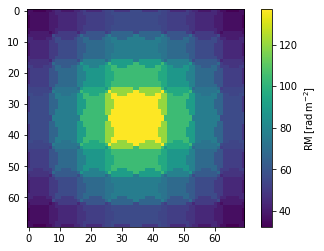

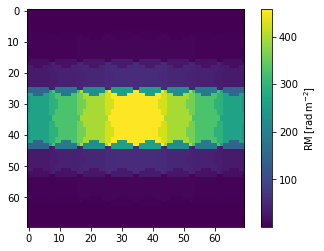

In [38]:
key = tuple(faceon_sim.keys())[0]
d = faceon_sim[key].data
plt.imshow(d.reshape(int(np.sqrt(d.size)),int(np.sqrt(d.size))))
plt.colorbar(label=r'$\rm RM\,[ rad\,m^{-2}]$')

plt.figure()
key = tuple(edgeon_sim.keys())[0]
d = edgeon_sim[key].data
plt.imshow(d.reshape(int(np.sqrt(d.size)),int(np.sqrt(d.size))))
plt.colorbar(label=r'$\rm RM\,[ rad\,m^{-2}]$')

## Priors

A powerful aspect of a fully Baysean analysis approach is the possibility of explicitly stating any prior expectations about the parameter values based on previous knowledge. 

In IMAGINE priors can be prescribed providing a mapping between uniformly distributed values to the actual distribution. The `GeneralPrior` class helps
doing this starting from a known PDF, or a previous sampling of the parameter space. 

To illustrate this, we will first construct a sample associated with a hipotetical parameter. To keep things simple but still illustrative, 
we construct this combining a uniform distribution and a normal distribution.

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

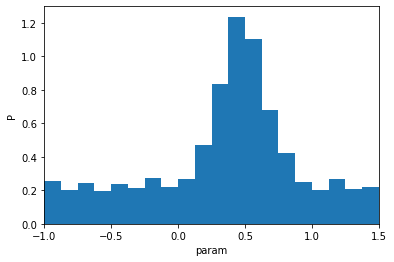

In [40]:
sample = np.concatenate([np.random.random_sample(2000),
                         np.random.normal(loc=0.6, scale=0.07, size=1500) ])
sample = sample*2.5-1
sample *= muG
plt.hist(sample.value, bins=20, density=True)
plt.ylabel('P'); plt.xlabel('param'); plt.xlim(-1,1.5);

This distribution could be the result of a previous inference exercise 
(i.e. a previously computed marginalised posterior distribution). 

From it, we can construct our prior using the `GeneralPrior` class. 
Lets say that, for some reason, we are only interested in the interval 
$[-0.9,1.5]$ (say, for example, $p=-1$ is unphysical), this can be accounted for 
with the argument `interval`.

In [41]:
from imagine import GeneralPrior
interval = (-0.9,1.5)*muG # 

prior_param = GeneralPrior(samples=sample, interval=interval)

del sample # to save memory

At this point we can inspect the PDF to see what we have.

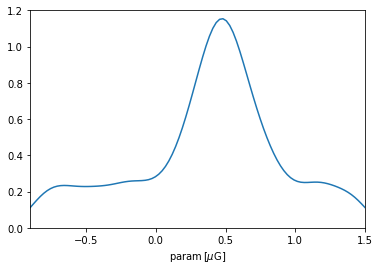

In [42]:
p = np.linspace(*interval, 100)
plt.plot(p, prior_param.pdf_unscaled(p))
plt.xlim(*interval.value); plt.ylim(0,1.2); plt.xlabel(r'param$\,[\mu\rm G]$');

A cautionary note: the KDE used in intermediate calculation tends so smoothen the distribution and forces a slight decay close to the endpoints (reflecting the fact that a Gaussian kernel was employed). For most practical applications,
this is not a big problem: one can control the degree of smoothness through the argument `bw_method` while initializing `GeneralPrior`, and the range close to endpoints are typically uninteresting. But it is recommended to always check the PDF of prior generated from a set of samples.

Alternatively, when one knows the analytic shape of given PDF, one can instead supply a function to `GeneralPrior`. In this case, the shape of the original function is generally respected. For example:

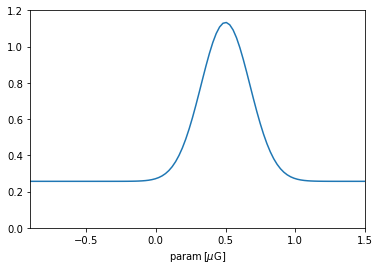

In [43]:
def example_pdf(y):
    x = y.to(u.microgauss).value # Handles units
    uniform_part = 1    
    sigma = 0.175; mu = 0.5
    gaussian_part = 1.5*( 1/(sigma * np.sqrt(2 * np.pi)) 
                         * np.exp( - (x - mu)**2 / (2 * sigma**2) ))
    return uniform_part + gaussian_part

prior_param = GeneralPrior(pdf_fun=example_pdf, interval=interval)

plt.plot(p, prior_param.pdf_unscaled(p))
plt.xlim(*interval.value); plt.ylim(0,1.2); plt.xlabel(r'param$\,[\mu\rm G]$');

Once the prior object was constructed, the IMAGINE Pipeline object uses it as the mapping above described to sample new paramters. Let us illustrate this concretely and check whether the prior is working (note that the Prior will
operate on scaled parameters, i.e. with values in the interval $[0,1]$).

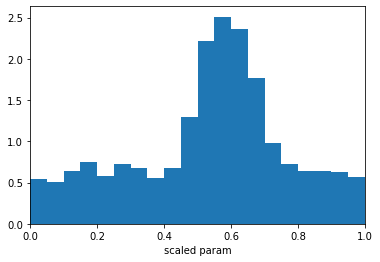

In [44]:
uniform_sample = np.random.random_sample(2000)
sampled_values = prior_param(uniform_sample)

plt.hist(sampled_values, bins=20, density=True)
plt.xlabel('scaled param'); plt.xlim(0,1);

Now we demonstrate a helper class which allows to easily construct priors from one [scipy.stats distributions](https://docs.scipy.org/doc/scipy/reference/stats.html). Lets say we wanted impose a [chi](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi.html) prior distribution for a 
given parameter.

In [45]:
import scipy.stats 

chiPrior = img.priors.scipyPrior(scipy.stats.chi, 3, loc=-10*muG, 
                                 scale=5*muG, interval=[-20,10]*muG)

The first argument of `img.priors.scipyPrior` is an instance of `scipy.stats.rv_continuous`, this is followed by any args required by the scipy distribution (in this specific case, `3` is the number of degrees of freedom in the chi-distribution). The keyword arguments loc and scale have the same meaning as in the `scipy.stats` case, and interval tells maximum and minimum parameter values that will be considered.

Let us check that this works, ploting the PDF and an histogram of parameter values sampled from the prior.

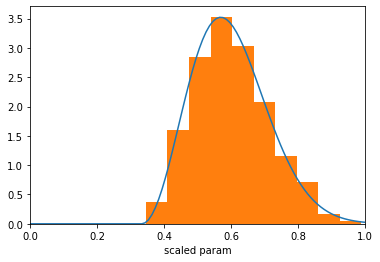

In [46]:
# Plots the PDF associated with this prior
t = np.linspace(0,1,100)
plt.plot(t, chiPrior.pdf(t))
# Plots the distribution of values constructed using this prior
x = np.random.random_sample(2000)
plt.hist(chiPrior(x), density=True);
plt.xlabel('scaled param'); plt.xlim(0,1);

Finally, if one already has the code that produces a MultiNest-compatible prior and one wants to use it directly, the simplest route is sub-classing the GeneralPrior and overriding its  `__init__` and `__call__` routines:

In [47]:
class silly_prior(GeneralPrior):
    
    def __call__(self,x):
        y = x.copy()
        y[x<0.17] = y[x<0.17]*2
        return y
    
silliness = silly_prior(interval=[3*u.tesla,2*muG])

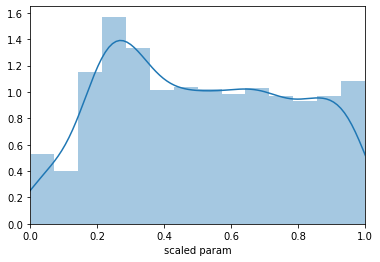

In [48]:
uniform_sample = np.random.random_sample(2000)
sampled_values = silliness(uniform_sample)

# plt.hist(sampled_values, bins=20, density=True)
sns.distplot(sampled_values)
plt.xlabel('scaled param'); plt.xlim(0,1);

## Likelihood

## Pipeline: adjusting the sampling